# Der g-h-Filter am Beispiel eines Abstandssensors
1.1.2019, S. Mack
## Vorbemerkungen
Dieses Jupyter-Notebook zum Kalmanfilter basiert auf den Notebooks von R. Labbe, welche auf GitHub unter github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python zugänglich sind.  
Die Inhalte wurden leicht geändert, und als Anwendungsbeispiel wird in dem hier vorliegenden Jupyter-Notebook die Abstandssensorik am Roboterfahrzeug des Projekts "Sensor- und Mikrosysteme" im Masterstudium Mechatronik an der Hochschule Reutlingen verwendet:  

<img src="RoboFahrzeugParallel.png" width="400">
  
Das Fahrzeug soll wie in der Zeichnung oben dargestellt in einem konstanten Abstand an der Wand entlang fahren. Der Abstand wird z.B. mit einem am Fahrzeug angebrachten Lidarsensor gemessen und dient als Eingangssignal für eine Regelung.  
Der Abstandsmesswert besitzt jedoch eine erhebliche statistische Streuung und ist mit häufigen Ausreißern behaftet, welche durch EMV-Probleme oder Fremdlicht verursacht sind. Für die zyklisch anfallenden Messdaten wird also ein Filter benötigt, der die Messwertstreuung reduziert und insbesondedere die Ausreißer entsprechend wenig gewichtet.  
Zudem verfügt die Wand über Nischen, denen das Roboterfahrzeug folgen soll. Daher kommt z.B. eine gleitende Mittelwertbildung nicht in Frage. Denn ein tatsächlicher Sprung der Abstandsmesswerte muss unmittelbar erkannt werden.  

Dies ist das optimale Einsatzgebiet eines **Kalmanfilters**. Der Kalmanfilter ist eine Spezialform des **g-h-Filters**. Daher macht es Sinn, sich zuerst mit diesem Filterkonzept zu befassen. Nachfolgend wird daher Schritt für Schritt ein g-h-Filter entwickelt und im folgenden Jupyter-Notebook mittels simulierter Abstandsmessdaten des Roboterfahrzeugs getestet.  
Aufbauend darauf wird später in einem gesonderten Jupyter-Notebook der Kalmanfilter behandelt.

In [1]:
#to render plots inside this notebook
%matplotlib inline
# import of python packages
import matplotlib.pyplot as plt

Nachfolgend werden die Python Packlages  `SciPy` (scipy.org), `NumPy` (numpy.org), und `Matplotlib` (matplotlib.org) verwendet. Der obige Python-Code ist für die Darstellung von Grafiken und Text in diesem Jupyter-Notebook nötig.

## Statische Abstandsmessungen
Das Fahrzeug steht parall zur Wand, der Lidar-Abstandssensor am Fahrzeug ist senkrecht zur Fahrtrichtung auf die Wand ausgerichtet.  
Der Sensor besitzt einen vernachlässigbaren Offsetfehler, da dieser vorher durch eine Kalibrierung auf weniger als 5 mm reduziert wurde. Da auf eine ebene Wand gemessen wird, und keine Mehrfachreflexe durch andere Objekte im Lichtkegel des Sensors entstehen, kommt kein weiterer systematische Messfehler hinzu. Ein möglicher Linearitätsfehler ist aufgrund der Laufzeitmessung zu vernachlässigen.  
Somit ist der Sensormesswert nur mit einem statistischen Fehler behaftet, der durch Rauschen der Sensorelektronik, durch Fremdlicht oder durch elektrische Störeinkopplungen verursacht wird.  
Wiederholt man die Messung bei stehendem Roboter, so streuen die Messwerte mit einer Normal- bzw. Gaußverteilung. Der wahre Abstand ist dabei der Erwartungswert. Die Breite der Streuung wird über die Standardabweichung $\sigma$ quantifiziert: Ein Vertrauensniveau von 99,73 % entspricht $3 \sigma$.   
Angenommen, man kennt die Standardabweichung des Abstandssensors (also dessen statistische Messunsicherheit) und darf aus Zeitgründen nur eine Messung vornehmen. Damit ergibt sich beispielsweise ein Messergebnis von 160 mm bei einer Messunsicherheit von 8 mm ($3 \sigma$) für diese Messung A.  
Was ändert sich, wenn zeitgleich eine weitere Messung B mit einem zusätzlichen, baugleichen Sensor durchgeführt wird? Die zweite Messung hat beispielsweise das Ergebnis 170 mm. Die Messunsicherhet ist hier ebenfalls 8 mm, da es sich ja um den *baugleichen* Sensor handelt.  

**Interpretation der Messung mit zwei Sensoren A und B**

Obwohl sich der Roboter nicht bewegt hat, differieren beide Messungen. Dies ist nicht wirklich verwunderlich, zumal beide Messungen einen statistischen Messfehler aufweisen. Wie kann man *beide* Messungen A und B berücksichtigen, um näher an den wahren Abstandswert zu kommen?  

Welche Optionen zur Messwertinterpretation gibt es?

* Nur dem Sensor A vertrauen.
* Nur dem Sensor B vertrauen.
* Annehmen, der wahre Abstand sei größer als beide Messwerte von Sensor A und B.
* Annehmen, der wahre Abstand sei kleiner als beide Messwerte von Sensor A und B.
* Annehmen, der wahre Abstand liege zwischen den Messwerten von Sensor A und B.

Die ersten beiden Optionen sind noch halbwegs plausibel. Aber wenn man keinen Anhaltspunkt dafür hat, wieso gerade nur eine der beiden Messungen gestört wurde, dann lässt sich für diese Optionen nur schwer argumentieren.  
Die Optionen drei und vier sind von vorneherein unplausibel. Es ist unwahrscheinlich, dass beide Messungen eine Abweichung mit selben Vorzeichen haben.  
Am wahrscheinlichsten ist es, dass die eine Messung über und die andere Messung unter dem wahren Wert liegt. Genau wie bei zweimaligem Würfeln ist es wahrscheinlicher, dass am Ende eine Augenzahl >3,5 und eine <3,5 heraus kommt, als dass zweimal >3,5 oder <3,5 Augen geworfen werden.

Die beste Schätzung für den wahren Abstandswert ist also $(160 mm +170 mm)/{2} = 165 mm$.

Dies lässt sich auch grafisch verdeutlichen mit zwei Messpunkten bei 160 bzw. 170 mm, die jeweils mit  $\pm$ 9 mm langen Fehlerbalken versehen sind. Auch hier ist intuitiv klar: Der wahre Abstandswert liegt im Überlappbereich der beiden Fehlerbalken.

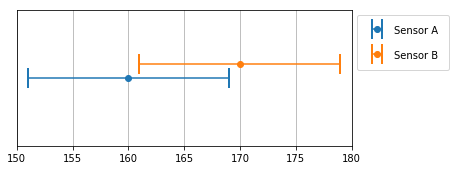

In [2]:
def plot_errorbars(bars, xlims, ylims=(-1, 1)): # plot function will be used later again
    plt.figure(figsize=(6,2.5))
    i = 0.0
    for bar in bars:
        plt.errorbar([bar[0]], [i], xerr=[bar[1]], fmt='o', label=bar[2] , capthick=2, capsize=10)
        i += 0.2
    plt.ylim(-1,1)
    plt.xlim(xlims[0], xlims[1])
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),borderpad=1, labelspacing=1.5)
    plt.gca().axes.yaxis.set_ticks([]) # no ticks on y-axis
    plt.grid()
    
plot_errorbars([(160, 9, 'Sensor A'), (170, 9, 'Sensor B')], xlims=(150, 180))

Bisher wurden beide Sensoren als baugleich angenommen. Dies war mit ein Grund für die Annahme, der wahre Abstandswert läge genau in der Mitte des Überlappbereichs der beiden Fehlerbalken.

Was ändert sich, wenn beide Sensoren einen unterschiedlichen statistischen Messfehler aufweisen. Zum Beispiel hat Sensor A jetzt nur $\pm$ 3 mm und Sensor B noch die dreifache Messunsichert von $\pm$ 9 mm. Dann überlappen beide Fehlerbalken immer noch, wie der nachfolgende Plot darstellt.

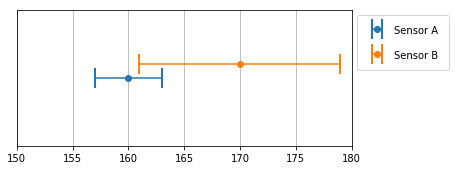

In [3]:
plot_errorbars([(160, 3, 'Sensor A'), (170, 9, 'Sensor B')], xlims=(150, 180))

Betrachtet man jetzt wieder die fünf Optionen der Messwertinterpretation, so liegt die Idee nahe, nur Sensor A zu vertrauen. Denn er liefert offensichtlich die genaueren Messwerte. Daraus ergäbe sich 160 mm als plausible Annahme des wahren Abstands.  
Doch eigentlich kann der wahre Abstand nicht 160 mm betragen. Denn Sensor B hätte dann unterhalb $3 \sigma$ abweichen müssen, was nur mit einer Wahrscheinlichkeit von $(1-0,9973)/2 = 0,14 \%$ vorkommt - also sehr unwahrscheinlich ist.  

Mit Blick auf den Plot oben ist ein wahrer Wert von 162 mm am plausibelsten.  

**Es wäre also falsch, den Messwert mit der höheren Unsichert zu ignorieren. Selbst ein schlechter Messwert ist immer noch besser als keiner!**

Im nächsten Plot ist die Situation weiter zugespitzt: Sensor A hat nun $\pm$ 2 mm und Sensor B $\pm$ 8 mm statistische Messunsicherheit:

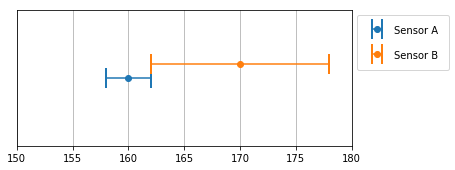

In [4]:
plot_errorbars([(160, 2, 'Sensor A'), (170, 8, 'Sensor B')], xlims=(150, 180))

Jetzt ist der einzig plausible Wert für den Abstand 162 mm. Zwei recht ungenaue Sensoren führen also zu einem fusionierte Messwert, der sehr genau ist.  
**Zwei Sensoren sind immer besser als einer, selbst wenn der zweite Sensor im Vergleich zum ersten sehr ungenau ist.**

Angenommen, die beiden Messwerte stammen nicht von zwei unterschiedlichen Sensoren sondern von ein und dem selben Sensor und wurden kurz nacheinander ausgeführt, ohne dass ich das Fahrzeug gegenüber der Wand bewegt hat?  
An der statistischen Analyse ändert sich nichts. Beide Messungen können auch eine unterschiedliche Messunsicherheit aufweisen, weil bei der zweiten Messung vielleicht mehr Störschall vorhanden war. Es gibt tatsächlich Sensoren, die bei jeder Messung die Standardabweichung mit ausgeben wie zum Beispiel die Lidar-Sensoren von STMicroelectronics.

## Wahrscheinlichkeitsdichteverteilungen
In den Plots oben deuten die Fehlerbalken an, dass der Messwert innerhalb dieser Bereiche mit gleicher Wahrscheinlichkeit streut. Diese "Wahrscheinlichkeitsdicheverteilung" nennt man eine Gleichverteilung. Über das Numpy Package wird eine solche Verteilung wie folgt generiert:

In [5]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print('Mittelwert Gelichverteilung: {:.4f}'.format(mean))

Mittelwert Gelichverteilung: 165.0162


Hier wurde eine gleichverteilte Zufallsgröße zwischen 160 und 170 generiert und in ein Array abgespeichert. Diese Stichprobe hat 10000 Elemente. Der Mittelwert ist wie zu erwarten nahe am Erwartungswert von 165. Erwartungswert nennt man den Wert, gegen den der Mittelwert für eine sehr große Stichprobe hin konvergiert.

Das Streuverhalten der Messwerte eines Abstandssensors wird durch eine Gleichverteilung nicht richig beschrieben. Eigentlich jeder Sensor gibt mit einer höheren Wahrscheinlichkeit einen Messwert aus, der nahe am wahren Wert liegt, als eine sogenannten "Ausreißer".  
Die Normalverteilung, oder Gaußverteilung, im Package numpy repräsetiert durch `numpy.random.normal()` modelliert sehr viel besser das reale Sensorverhalten.  
Stellt man sich die Messwertstreuung eines Sensors als Ergebnis vieler kleiner Störfaktoren vor, dann kann man sogar über den "zentralen Grenzwertsatz" beweisen, dass die Normalverteilung am besten dem realen Sensorverhalten entspricht.

In [6]:
mean = np.random.normal(165, 5, size=10000).mean()
print('Mittelwert Normalverteilung: {:.4f}'.format(mean))

Mittelwert Normalverteilung: 164.9668


## Abstandsmessung bei bewegtem Fahrzeug
Nun soll das Fahrzeug entlang der Wand fahren und mit seinem (einen) Abstandssensor jede Sekunde den Abstand zur Wand messen. Der Takt der Messungen wird als "*Abtastzeit*" bezeichnet. Der zeitliche Verlauf dieser Messung könnte so aussehen wie im nachfolgendem Plot, welcher drei aufeinander folgende Messwerte darstellt:

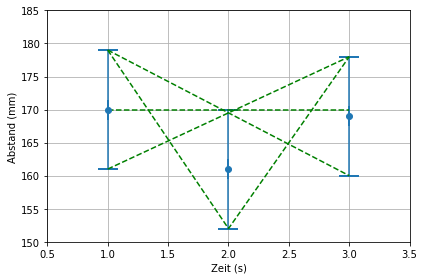

In [7]:
plt.figure()
plt.errorbar([1, 2, 3], [170, 161, 169],xerr=0, yerr=9, fmt='o', capthick=2, capsize=10)

plt.plot([1, 3], [179, 160], color='g', ls='--')
plt.plot([1, 3], [170, 170], color='g', ls='--')
plt.plot([1, 3], [161, 178], color='g', ls='--')
plt.plot([1, 2, 3], [179, 152, 178], color='g', ls='--')
plt.xlim(0.5,3.5)
plt.ylim(150, 185)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
plt.grid()
plt.tight_layout()

## Aus dem zeitlichen Verlauf der drei Abstandsmessungen lassen sich völlig unterschiedliche mögliche Bewegungsmuster des Fahrzeugs interpretieren, von denen die extremen mit grün gestrichelten Linien dargestellt sind:  
Das Fahrzeug kann schräg zur Wand hin oder weg fahren. Auch kann es perfekt parallel zu Wand oder in einem Zickzack-Kurs fahren.

Was ist der plausibelste Bewegungsverlauf?  
Die Antwort darauf wird einfacher, wenn das physikalische System (=Farzeug) bekannt ist: Hat das Fahrzeug z.B. keine Lenkung und wurde es beim Start exakt parallel zur Wand ausgerichtet, dann wäre die Hypothese der exakt parallelen Bewegung zu Wand am plausibelsten.  
**Das Wissen über das physikalische System, genauer gesagt ein Modell davon, beeinflusst die Interpretation der an ihm vorgenommenen Messwerte.**  

Je mehr aufeinander folgende Messwerte vorhanden sind, desto besser können die Messwerte mit Hilfe des physikalischen Modells erklärt werden. Der nachfolgende Plot zeigt einen neuen Messwerteverlauf über 12 Sekunden. 
 

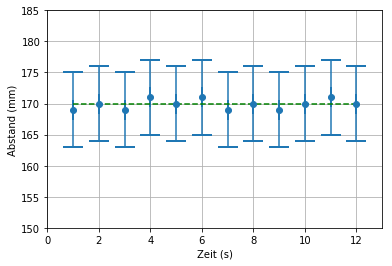

In [8]:
plt.figure()
plt.errorbar(range(1, 13), [169, 170, 169,171, 170, 171, 169, 170, 169, 170, 171, 170],
    xerr=0, yerr=6, fmt='o', capthick=2, capsize=10)
plt.plot([1, 12], [169.9, 169.9], color='g', ls='--')       
plt.xlim(0, 13)
plt.ylim(150, 185)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
plt.grid()

Ein plausibler Verlauf der wahren Abstandswerte ist hier grün gestrichelt dargestellt. Es wäre auch möglich eine Zickzack-Bewegung an die Messdaten anzupassen. Aber in Kenntnis des physikalischen Modells (Fahrzeug ohne Lenkung, paralleler Start zur Wand) ist die Zick-Zack-Bewegung sehr unwahrscheinlich.  
Die grün gestrichelte Linie muss nicht den wahren Verlauf der Wandabstände repräsentieren. Jedoch steht sie für ein Bewegungsmuster, welches für das verwendetete Fahrzeug vernünftig erscheint.  

Eine andere Messung ergibt beispielsweise folgenden Messwertverlauf:

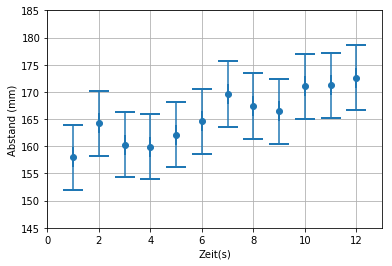

In [9]:
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6,169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
plt.figure()
plt.errorbar(range(1, 13), measurements, xerr=0, yerr=6, fmt='o', capthick=2, capsize=10)
plt.xlim(0, 13)
plt.ylim(145, 185)
plt.xlabel('Zeit(s)')
plt.ylabel('Abstand (mm)')
plt.grid()

Diese Messdaten passen auf keinen Fall zur einer Hypothese, das Fahrzeug würde sich schräg auf die Wand zu bewegen.  
Im folgenden Plot wird eine dazu plausiblere Hypothese mit einer roten Linie visualisiert: Das Fahrzeug bewegt sich exakt parallel zu Wand bewegt:

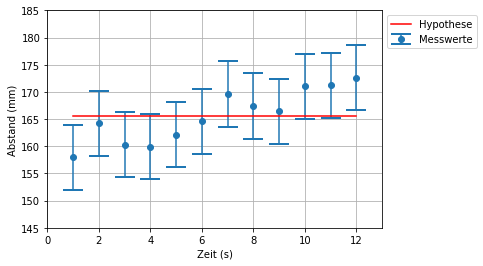

In [10]:
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
plt.figure()
ave = np.sum(measurements) / len(measurements)
plt.errorbar(range(1,13), measurements, label='Messwerte', yerr=6, fmt='o', capthick=2, capsize=10)
plt.plot([1, 12], [ave,ave], c='r', label='Hypothese')
plt.xlim(0, 13)
plt.ylim(145, 185)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid()

Die Hypothese im Plot oben überzeugt jedoch auch nicht wirklich: Es gibt keine horizontale Linie, die innerhalb der Fehlerbalken aller Messwerte verläuft.

Im nächsten Plot ist ein lineare "least squares fit" - eine Ausgleichsgerade - als Hypothese eingezeichnet. (Die Gerade wird mit der Methonde `polyfit()` aus dem numpy Package berechnet.)

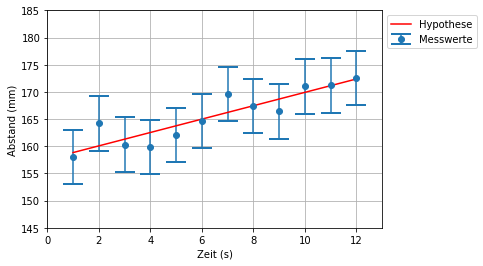

In [11]:
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
xs = range(1, len(measurements)+1)
line = np.poly1d(np.polyfit(xs, measurements, 1))
plt.figure()
plt.errorbar(range(1, 13), measurements, label='Messwerte',yerr=5, fmt='o', capthick=2, capsize=10)
plt.plot (xs, line(xs), c='r', label='Hypothese')
plt.xlim(0, 13)
plt.ylim(145, 185)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid()

Diese Hypothese ist bedeutend besser als die vorherige. Das Fahrzeug scheint sich also schräg von der Wand weg zu bewegen und fährt entlang einer geraden Linie. Etwa wie in der Skizze unten dargestellt.

<img src="RoboFahrzeug15Grad.png" width="400">

Glaubt man der roten Linie, dann hat sich das Fahrzeug zwischen Sekunde 1 und 12 um 13 mm von der Wand weg bewegt.

## Vorhersage des Messwerts aufgrund eines physikalischen Modells
Im Folgenden wird gezeigt, wie mit einem einfachen Modell des Fahrzeugs der nächste Messwert vorhergesagt werden kann. Dabei muss die Vorhersage nicht genau mit der Realität übereinstimmen - es reicht, wenn das Modell in etwa der Realität entspricht. Konkret am Beispiel des Fahrzeugs: Es muss nicht super exakt im vorgegebenen Winkel zur Wand ausgerichtet werden und es darf auch etwas schief fahren. 
Für den oben im Plot dargestellten Bewegungsverlauf wird etwas abweichend zur Ausgleichsgerade angenommen, das Fahrzeug würde sich pro Sekunde um 1 mm von der Wand weg bewegen.

Der erste Messwert ist wie oben wieder der Abstand 158 mm, gemessen zur Zeit 1 s. Das oben formulierte Modell ermöglicht dann folgende Vorhersage für die Zeit 2 s also für den nächsten Messwert:

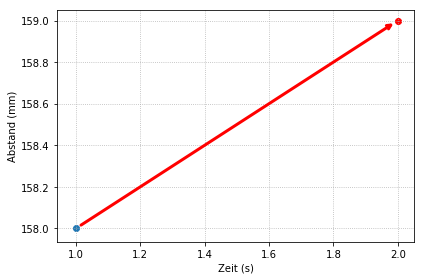

In [12]:
plt.figure()
ax = plt.axes()
ax.annotate('', xy=[2,159], xytext=[1,158], arrowprops=dict(arrowstyle='->', ec='r',shrinkA=6, lw=3,shrinkB=5))
plt.scatter ([1], [158], c='C0')
plt.scatter ([2], [159], c='r')
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
ax.xaxis.grid(True, which="major", linestyle='dotted')
ax.yaxis.grid(True, which="major", linestyle='dotted')
plt.tight_layout()

Eigentlich könnten wir diese Vorhersage (1 mm mehr Wandabstand pro Sekunde) auch für die nächsten zehn Sekunden fortführen. Dies würde aber vermutlich zu einer zunehmenden Diskrepanz zwischen Vorhersage und wahrem Abstandswert führen. Denn das hier zugrunde gelegte Fahrzeugmodell wird sicher nicht exakt der Realität entsprechen!  
Zum Glück gibt es ja für die zweite Messung bei 2 s wieder einen Messwert, der mit der (auf der ersten Messung basierenden) Vorhersage verglichen werden kann.  
Folgender Plot verdeutlicht dies. Mit "letzter Schätzwert" ist die erste Messung gemeint. Dass diese Bezeichnung Sinn macht wird erst dann deutlich, wenn man dieses Verfahren von Messung zu Messung, also jede Sekunde immer erneut anwendet: Dann ist der Ausgangswert für eine Vorhersage immer das Ergebnis der letzten Schätzung. Wobei die Schätzung jeweils ein Kompromiss zwischen der letzten Vorhersage und dem aktuellen (vorhergesagten) Messwert ist.  
Keine Panik! Später wird diese Rekursion näher erläutert - sie ist der Kernalgorithmus eines Kalmanfilters.

(157, 164.5)

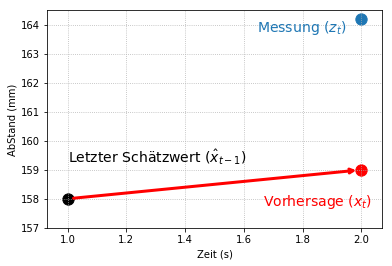

In [13]:
plt.figure()
ax = plt.axes()
ax.annotate('', xy=[2,159], xytext=[1,158],arrowprops=dict(arrowstyle='->',ec='r', lw=3, shrinkA=6, shrinkB=5))
plt.scatter ([1], [158.0], c='k',s=128)
plt.scatter ([2], [164.2], c='C0',s=128)
plt.scatter ([2], [159], c='r', s=128)
plt.text (1.85, 158.2, "Vorhersage ($x_t)$", ha='center',va='top',fontsize=14,color='r')
plt.text (1.95, 164.2, "Messung ($z_t$)",ha='right',va='top',fontsize=14,color='C0')
plt.text (1.0, 159.8, "Letzter Schätzwert ($\hat{x}_{t-1}$)", ha='left', va='top',fontsize=14)
plt.xlabel('Zeit (s)')
plt.ylabel('AbStand (mm)')
ax.xaxis.grid(True, which="major", linestyle='dotted')
ax.yaxis.grid(True, which="major", linestyle='dotted')
plt.ylim(157, 164.5)

Der "letzte Schätzwert" ist also der Messwert $\hat x_t = 158 mm$ zur Zeit $t-1 = 1 s$. Darauf aufbauend wird die Vorhersage gemacht, dass der Abstand eine Sekunde später zur Zeit  $t = 2 s$ um 1 mm auf $z_t = 159 mm$ angewachsen ist. Genau zu dieser Zeit liegt aber wieder ein aktueller Messwert $x_t = 164,2 mm$ vor.  
Die Vorhersage und der aktuelle Messwert weichen also voneinander ab. Es gibt hier ein Problem. Aber es war auch nicht anders zu erwarten.  

> **Achtung: In den folgenden Abschnitten werden die Kerngedanken eines Kalmanfilters (hier als Vorstufe der g-h-Filter) formuliert. Nur wer diese Gedanken nachvollziehen kann, wird in den späteren Abschnitten ohne größere Probleme die Idee eines Kalmanfilters verstehen!** 

Alleine nur der aktuellen Messung oder nur der Vorhersage zu vertrauen, macht keinen Sinn. Man würde dann wertvolle Informationen misachten bzw. nicht nutzen.  
**Die Kernaufgabe besteht nun darin, die Vorhersage und den aktuellen Messwert so zu kombinieren, dass daraus ein neuer optimaler Schätzwert entsteht**.

Die Kombiantion zweier Größen, die beide einen statistischen Fehler aufweisen, war im Abschnitt *Statische Abstandsmessung* schon einmal Thema. Dort waren es die verrauschten Messwerte zweier Abstandssensoren A und B. Hier ist es eine "verrauschte" Vorhersage und eine verrauschte Messung.  
Für die Mathematik macht es keinen Unterschied, ob es sich um einen Messwert oder um einen Vorhersagewert handelt. Beide Werte sind *Daten* und können mit einem Erwartungswert und einer Standardabweichung charakterisiert werden.  
Bei den Abstandsmessungen der beiden Sensoren A und B aus der Einleitung dieses Jupyter-Notebooks, wurde deutlich, dass der wahre Wert am wahrscheinlichen im Überlappbereich der beiden Fehlerbalken liegt.  
Auch wurde kar: Selbst wenn einer der beiden Sensoren sehr stark streut, ist es immer besser beide Sensorwerte zu kombinieren, als nur den mit dem kleinsten Fehlerbalken zu verwenden.  

Auch wenn die Vorhersage nur wenig spezifisch ist, d.h. wenn sie mit einer großen Fehlerbandbreite behaftet ist, auch dann sollte man sie verwenden, um den aktuellen Messwert damit in einen neuen exakteren Schätzwert zu überführen. Man sollte **nie Informationen wegwerfen**!

**Entscheidend ist nun, *wo* der neue Schätzwert $\hat x_t$ zwischen Vorhersage und aktuellem Messwert verortet wird.** Näher an der Vorhersage oder näher am aktuellen Messwert? Dies verdeutlicht der nachfolgende Plot.

(157, 164.5)

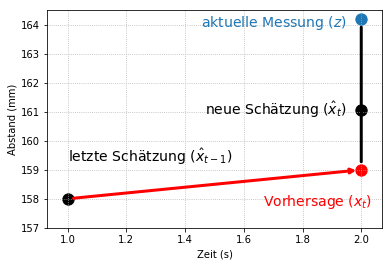

In [14]:
plt.figure()
ax = plt.axes()
ax.annotate('', xy=[2,159], xytext=[1,158], arrowprops=dict(arrowstyle='->',
            ec='r', lw=3, shrinkA=6, shrinkB=5))
ax.annotate('', xy=[2,159], xytext=[2,164.2], arrowprops=dict(arrowstyle='-',
            ec='k', lw=3, shrinkA=8, shrinkB=8))
est_y = (159 + .4*(164.2-159))
plt.scatter ([1,2], [158.0,est_y], c='k',s=128)
plt.scatter ([2], [164.2], c='C0',s=128)
plt.scatter ([2], [159], c='r', s=128)
plt.text (1.85, 158.2, "Vorhersage ($x_t)$", ha='center',va='top',fontsize=14,color='r')
plt.text (1.95, 164.4, "aktuelle Messung ($z$)",ha='right',va='top',fontsize=14,color='C0')
plt.text (1, 159.8, "letzte Schätzung ($\hat{x}_{t-1}$)", ha='left', va='top',fontsize=14)
plt.text (1.95, est_y, "neue Schätzung ($\hat{x}_{t}$)", ha='right', va='center',fontsize=14)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
ax.xaxis.grid(True, which="major", linestyle='dotted')
ax.yaxis.grid(True, which="major", linestyle='dotted')
plt.ylim(157, 164.5)

**Anmerkung zur Notation:**  
Die Größen $z$ sind immer Messwerte. Die Größen $x$ ohne Dach sind immer Vorhersagen und die Größen $\hat x$ mit Dach sind die aus den Messwerten und Vorhersagen errechneten Schätzwerte.  
Wie vorhin schon erwähnt, ist es anfangs etwas verwirrend, den ersten Messwert zur Zeit 1 s auch als Schätzwert zu bezeichnen. Dies beruht darauf, dass nur ganz am Anfang ein Messwert als erster Schätzwert verwendet werden muss, weil kein vorheriger Schätzwert vorhanden ist. In den nächsten Iterationsrunden, liegt jedoch immer ein letzter Schätzwert als Startpunkt vor.

## Entwicklung eines Filters
Im Plot oben wurde der Einfachheit halber angenommen, der aktuelle Messwert habe eine 1,5-fach so große statistische Unsicherheit wie die Vorhersage. Daher wird der neue Schätzwert "von der Vorhersage auf 40 % in Richtung aktueller Messwert" gesetzt. Anders ausgedrückt: Der neue Schätzwert errechnet sich zu 60 % aus der Vorhersage und zu 40 % aus dem aktuellen Messwert. Der Vorhersage wird also mehr vertraut als dem aktuellen Messwert. Mathematisch wird dies so formuliert:

$$\text{neue  Schätzung} = \text{Vorhersage} + \frac{4}{10}\text{(aktuelle Messung - Vorhersage)}$$

Die Differenz zwischen der Vorhersage und dem aktuellen Messwert nennt man Restwert (englisch "*residual*"). Im Plot oben ist dieser Wert mit der schwarzen vertikalen Linie visualisiert.  

**Die oben genannte Berechnung des neuen Schätzwerts aus der letzten Schätzung und dem aktuellen Messwert ist der erste Schritt zu einem g-h-Filter.** Im folgenden Quellcode wird dieser Filter 12 mal iterativ angewendet: Der neue Schätzwert ist dabei immer der letzte Schätzwert für die nächste Iteration. Da 12 Messwerte und ein Startwert existieren, kann der Filter 12 mal angewendet werden.  
Für jede Iteration werden die verschiedenen Parameter in Textform ausgegeben.  

Wieder taucht hier die Frage auf, woher der erste "letzte Schätzwert" herkommt. Dieser Startwert wird nun einfach geraten: Es wird angenommen, das Fahrzeug befinde sich zu Beginn in einem Abstand von 160 mm zur Wand.

In [15]:
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

scale_factor = 4.0/10

# filter function will be used later again
def filter(zero_estimate, dist_rate):     
    # store the filtered results
    estimates, predictions = [zero_estimate], []
    estimate = zero_estimate
    # most filter literature uses 'z' for measurements
    for measurement in measurements:
        # predict new position
        old_estimate = estimate
        prediction = estimate + dist_rate         
        # update filter: Neuen Schätzwert berechnen
        estimate = prediction + scale_factor * (measurement - prediction)
        # save
        estimates.append(estimate)
        predictions.append(prediction)
        print('Letzte Schätz.: {:.2f},  Vorhers.: {:.2f},  Mess.: {:.2f},  neue Schätz.: {:.2f}'.
            format(old_estimate, prediction, measurement, estimate))
    return estimates, predictions

initial_guess = 160.0

estimates, predictions = filter(zero_estimate=initial_guess, dist_rate=1)     

Letzte Schätz.: 160.00,  Vorhers.: 161.00,  Mess.: 158.00,  neue Schätz.: 159.80
Letzte Schätz.: 159.80,  Vorhers.: 160.80,  Mess.: 164.20,  neue Schätz.: 162.16
Letzte Schätz.: 162.16,  Vorhers.: 163.16,  Mess.: 160.30,  neue Schätz.: 162.02
Letzte Schätz.: 162.02,  Vorhers.: 163.02,  Mess.: 159.90,  neue Schätz.: 161.77
Letzte Schätz.: 161.77,  Vorhers.: 162.77,  Mess.: 162.10,  neue Schätz.: 162.50
Letzte Schätz.: 162.50,  Vorhers.: 163.50,  Mess.: 164.60,  neue Schätz.: 163.94
Letzte Schätz.: 163.94,  Vorhers.: 164.94,  Mess.: 169.60,  neue Schätz.: 166.80
Letzte Schätz.: 166.80,  Vorhers.: 167.80,  Mess.: 167.40,  neue Schätz.: 167.64
Letzte Schätz.: 167.64,  Vorhers.: 168.64,  Mess.: 166.40,  neue Schätz.: 167.75
Letzte Schätz.: 167.75,  Vorhers.: 168.75,  Mess.: 171.00,  neue Schätz.: 169.65
Letzte Schätz.: 169.65,  Vorhers.: 170.65,  Mess.: 171.20,  neue Schätz.: 170.87
Letzte Schätz.: 170.87,  Vorhers.: 171.87,  Mess.: 172.60,  neue Schätz.: 172.16


Die Ergebnisse der 12 Iterationen oben werden nun grafisch in folgendem Plot dargestellt:

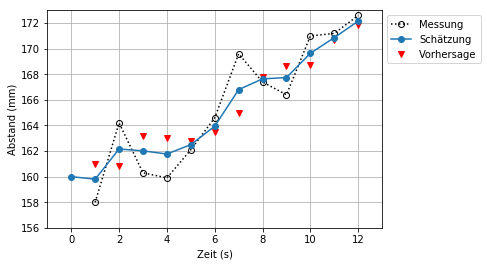

In [16]:
# filter data plot function will be used later again
def plot_filter(measurements, estimates, predictions):
    plt.figure()
    n = len(measurements)
    xs = range(n+1)
    pred, = plt.plot(xs[1:], predictions, c='r', marker='v', linestyle='None')
    meas, = plt.plot(xs[1:], measurements, color='k', marker = 'o', linestyle=':', mfc='None')
    est, = plt.plot(xs, estimates, marker='o')  
    plt.legend([meas, est, pred], ['Messung', 'Schätzung', 'Vorhersage'], loc="upper left", bbox_to_anchor=(1,1))
    plt.xlabel('Zeit (s)')
    plt.ylabel('Abstand (mm)')
    plt.xlim([-1, n+1])
    plt.ylim([156.0, 173])
    plt.grid()

plot_filter(measurements, estimates, predictions)

Die blaue Kurve mit den Schätzwerten ist der Output des gh-Filters. Sie beginnt mit dem geratenen Startwert von 160 mm für den "ersten Schätzwert" des Abstands.  
Es ist gut sichtbar, dass der aktuelle Schätzwert (blauer Vollkreis) immer doppelt so nahe am Vorhersagewert (rotes Dreieck) liegt wie am aktuellen Messwert (schwarzer Kreis). Die Schätzwerte liegen nicht auf einer geraden Linie, wie die wahren Werte des Fahrzeugs, welches sich leicht schräg von der Wand weg bewegt. Ihre Spur (blaue Linie) ist aber deutlich weniger holprig als die der Messwerte (gepunktete schwarze Linie).  

Dieser einfache Filter zeigt also eine erstaunliche Wirkung. Dies hängt nicht unbedingt vom richtig geratenem Startwert oder vom exakt erstellten physikalischen Modell ab. Folgende Plots untersuchen nun die Robustheit des Filters.  
Zuerst wird ein anderer Startwert `initial_guess` verwendet: 

Letzte Schätz.: 164.00,  Vorhers.: 165.00,  Mess.: 158.00,  neue Schätz.: 162.20
Letzte Schätz.: 162.20,  Vorhers.: 163.20,  Mess.: 164.20,  neue Schätz.: 163.60
Letzte Schätz.: 163.60,  Vorhers.: 164.60,  Mess.: 160.30,  neue Schätz.: 162.88
Letzte Schätz.: 162.88,  Vorhers.: 163.88,  Mess.: 159.90,  neue Schätz.: 162.29
Letzte Schätz.: 162.29,  Vorhers.: 163.29,  Mess.: 162.10,  neue Schätz.: 162.81
Letzte Schätz.: 162.81,  Vorhers.: 163.81,  Mess.: 164.60,  neue Schätz.: 164.13
Letzte Schätz.: 164.13,  Vorhers.: 165.13,  Mess.: 169.60,  neue Schätz.: 166.92
Letzte Schätz.: 166.92,  Vorhers.: 167.92,  Mess.: 167.40,  neue Schätz.: 167.71
Letzte Schätz.: 167.71,  Vorhers.: 168.71,  Mess.: 166.40,  neue Schätz.: 167.79
Letzte Schätz.: 167.79,  Vorhers.: 168.79,  Mess.: 171.00,  neue Schätz.: 169.67
Letzte Schätz.: 169.67,  Vorhers.: 170.67,  Mess.: 171.20,  neue Schätz.: 170.88
Letzte Schätz.: 170.88,  Vorhers.: 171.88,  Mess.: 172.60,  neue Schätz.: 172.17


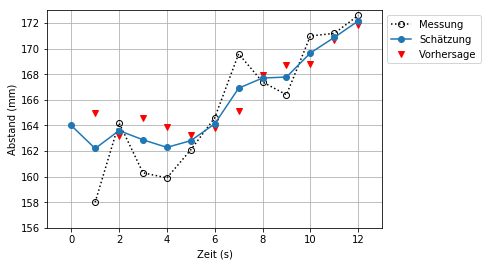

In [17]:
wrong_initial_guess = 164.0
right_dist_rate = 1
estimates, predictions = filter(zero_estimate=wrong_initial_guess, dist_rate=right_dist_rate)
plot_filter(measurements, estimates, predictions)

Ein schlechterer Startwert lässt den Filter nur während der ersten Iterantionen vom wahren Bewegungsverlauf deutlich abweichen, wie der Plot oben verdeutlicht. Der Filter korrigiert sich schnell selbst.  
Im folgenden Plot ist zusätzlich ein falsches physikalisches Modell angenommen: Die Abstandszunahme `dist_rate` wird als -1 mm statt 1 mm pro Sekunde angenommen. Das Modell nimmt also an, das Fahrzeug würde schräg auf die Wand zu fahren!

Letzte Schätz.: 164.00,  Vorhers.: 163.00,  Mess.: 158.00,  neue Schätz.: 161.00
Letzte Schätz.: 161.00,  Vorhers.: 160.00,  Mess.: 164.20,  neue Schätz.: 161.68
Letzte Schätz.: 161.68,  Vorhers.: 160.68,  Mess.: 160.30,  neue Schätz.: 160.53
Letzte Schätz.: 160.53,  Vorhers.: 159.53,  Mess.: 159.90,  neue Schätz.: 159.68
Letzte Schätz.: 159.68,  Vorhers.: 158.68,  Mess.: 162.10,  neue Schätz.: 160.05
Letzte Schätz.: 160.05,  Vorhers.: 159.05,  Mess.: 164.60,  neue Schätz.: 161.27
Letzte Schätz.: 161.27,  Vorhers.: 160.27,  Mess.: 169.60,  neue Schätz.: 164.00
Letzte Schätz.: 164.00,  Vorhers.: 163.00,  Mess.: 167.40,  neue Schätz.: 164.76
Letzte Schätz.: 164.76,  Vorhers.: 163.76,  Mess.: 166.40,  neue Schätz.: 164.82
Letzte Schätz.: 164.82,  Vorhers.: 163.82,  Mess.: 171.00,  neue Schätz.: 166.69
Letzte Schätz.: 166.69,  Vorhers.: 165.69,  Mess.: 171.20,  neue Schätz.: 167.89
Letzte Schätz.: 167.89,  Vorhers.: 166.89,  Mess.: 172.60,  neue Schätz.: 169.18


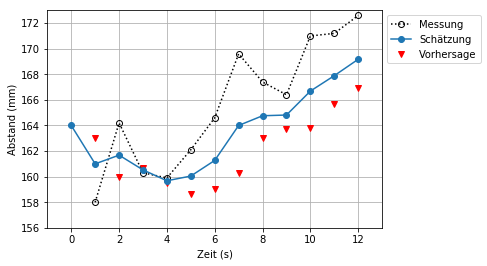

In [18]:
wrong_initial_guess = 164.0
wrong_dist_rate = -1
estimates, predictions = filter(zero_estimate=wrong_initial_guess, dist_rate=wrong_dist_rate)
plot_filter(measurements, estimates, predictions)

Anders als bei einem falschen Startwert wirft ein falsches physikalisches Modell unseren Filter aus der Bahn. Dies ist auch der Fall, wenn der Startwert richtig gewesen wäre. Trotzdem liegt der Filter nicht ganz und gar falsch: Obwohl das physikalische Modell ihm nahelegt, das Fahrzeug würde schräg auf die Wand zu fahren, macht der Filter dennoch die realitätsnahe Vorhersage eines *Wegfahrens* von der Wand. Dies jedoch mit einem deutlichen Offset zum wahren Bewegungsverlauf. 

Unser Filter muss also nur noch etwas anpassungsfähgier werden: Er muss während seiner Ausführung Parameter des physikalischen Modells optimieren können.  
Konkret heißt das: Das physikalische Modell selbst nimmt nur an, das Fahrzeug bewege sich geradlinig. in welchem Winkel das Fahrzeug zur Wand hin oder weg fährt, wird durch einen Parameter dieses Modells bestimmt. Für diesen Parameter gibt es schon die Variable `dist_rate` für die Annäherungsgeschwindigkeit zur Wand. Der Wert dieser Variablen sollte durch den Filter selbst aufgrund der Messdaten optimiert werden können.  

Zurück zum ersten Plot des Filterverlaufs mit Startwert 160 mm und Abstandsänderung von 1 mm/s:  
Die Vorhersage hier für den ersten Messwert zur Zeit 1 s lautet:

$$(160 + 1) mm + \frac{4}{10}(158 mm-161 mm) = 159.8 mm$$

Tatsächlich wird zu dieser Zeit aber ein Abstand von 164,2 mm gemessen, was eine Abstandsänderung *nicht* von 1 mm/s sondern von 4,4 mm/s impliziert. Diese Information zur Abstandsänderung ist zwar verrauscht aber immer noch nützlicher als die aus der Luft gegriffene Annahme, das Fahrzeug würde sich ein für alle mal mit 1 mm/s von der Wand entfernen.  

*Informationen aus Messdaten sind aber nützlicher als bloße theoretische Annahmen, selbst wenn die Messdaten stark verrauscht sind. Daher sollte man keine Sensordaten verwerfen, sondern sie nutzen!*  

Nun ist folgende Frage berechtigt: Es werden ja schon alle Sensormesswerte genutzt, um damit einen neuen Schätzwert für den Abstandswert zu bilden.  
>*Frage:* Welche Information wird verworfen, wenn die zeitliche Änderung der Messdaten nicht genutzt wird? Wofür ist die zeitliche Änderung nützlich?  
*Antwort:* Die zusätzliche Information steckt in der **zeitlichen Korrelation der Messwerte, mit Hilfe eines physikalischen Modells wird damit der zukünftiger Verlauf der Messdaten extrapoliert**.

Mit welchem Algorithmus kann man den Parameter `dist_rate` der Abstandsänderung flexibel gestalten, so dass er sich aufgrund des Messwertverlaufs selbst optimiert?  
Es ist naheliegend, hier genau so zu verfahren, wie bei der Berechnung des neuen Schätzwerts aus dem aktuellen Messwert und der Vorhersage:  
Wurde vorher die Abstandsänderung als 1 mm/s angenommen und stellt sich aufgrund des aktuellen Messwertes heraus, dass sie im Vergleich zum vorherigen Messwewrt 4,4 mm/s beträgt, so wird für die nächste Iteration (=Abtastung) eine Abstandsänderung zwischen diesen beiden Werten angenommen.  

Analog wie bei der Verrechnung des aktuellen Messwerts mit der Vorhersage wird die neue Abstandsänderung zu 70 % aus der  alten und zu 30 % aus der Abweicheung Messwert zu Vorhersage berechnet. Je besser die Vorhersage den aktuellen Messwert voraussagt, desto weniger wird die aktuelle Abstandsänderung geändert. Die konkreten Prozentwerte hier sind willkürlich - also wieder ein Schuss aus der Hüfte.  
Allgemein wird die Abstandsänderung als Verstärkung (englisch "*gain*") des Filters bezeichnet.

Die hieraus resultierende Gleichung für die Abstandsänderung ist somit der für die neue Schätzung des Messwerts sehr ähnlich:

$$\text{neue Abstandsänderung} = \text{alte Abstandsänderung} + \frac{1}{3}\frac{\text{aktuelle Messung - Vorhersage}}{ \text{s}}$$

Zusätzlich zum ersten Schätzwert für den Wandabstand muss jetzt auch die erste Abstandsänderung "geraten" werden. 

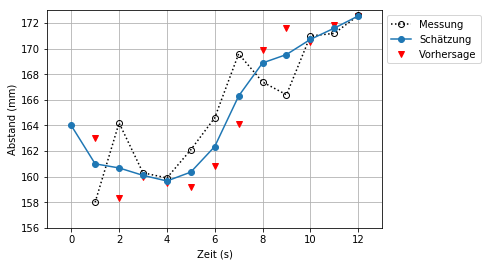

In [19]:
initial_guess_meas = 164.
initial_guess_gain = -1.0 
meas_scale = 4./10
gain_scale = 1./3
estimates = [initial_guess_meas]
predictions = []

gain = initial_guess_gain
measurement = initial_guess_meas

for z in measurements:
    # prediction step
    measurement = measurement + gain
    gain = gain # the model gives no prediction for the gain
    predictions.append(measurement)
    
    # update step    
    residual = z - measurement
    gain = gain + gain_scale   * (residual) # model parameter gain is updated
    measurement    = measurement    + meas_scale * residual # new estimade is calculated
  
    estimates.append(measurement)

plot_filter(measurements, estimates, predictions)

Jetzt macht der Filter wirklich gute Arbeit: Trotz falsch angenommenem Abstand und Abstandsänderung beim Start dauert es nur wenige Sekunden, bis der Filter die Abstandswerte sehr realitätsnah ausgibt. Dann "trackt" sozusagen die  Abstandsmesswerte.  
Die beiden Skalierungsfaktoren `meas_scale` und `gain_scale` $\frac{4}{10}$ bzw. $\frac{1}{3}$ sind aus der Hüfte geschossen - funktionieren aber trotzdem sehr gut. Sie bleiben die einzig willkürlich gewählten Parameter des Filters.  

Die Codezeile
```python
gain_rate = gain_rate
``` 
soll verdeutlichen, dass iterativ nur Vorhersagen des Messwerts nicht aber Vorhersagen der Abstandsänderung gemacht werden. Denn bis hierhin wurde ein physikalisches Modell verwendet, bei dem es keine Aussage über einen zeitlichen Verlauf der Abstandsänderung gibt. Konkret für das Fahrzeug bedeutet dies, das Fahrzeug fährt an sich nur geradlinig mit konstanter Geschwindigkeit zur Wand hin oder von der Wand weg.  
In einer späteren Weiterentwicklung des Filters wird der Gain (=Abstandsänderung) auch Gegenstand einer Vorhersage werden.

## Der g-h-Filter

Den im vorherigen Abschnitt nun fertig entwickelten Filteralgorithus bezeichnet man als **g-h-Filter** oder auch $\alpha$-$\beta$-Filter.  
**Die Buchstaben $g$ und $h$ stehen für die beiden beiden Skalierungsfaktoren `meas_scale` und `gain_scale`.**  $\alpha$ und $\beta$ sind nur andere Bezeichnungen dieser Faktoren.  
Der g-h-Filter ist die Basis für verschiedenste Filteralgorithmen, die bei der Sensordatenverarbeitung zur Anwendung kommen. **Auch der Kalmanfilter ist eine Spezialform des g-h-Filters**.

Zum Ende dieser Einführung in die Welt der Kalmanfilter werden die bis hierhin behandelten Kernthesen nun wiederholt. Es ist absolut wichtig, diese zu verstehen, wenn ein Kalmanfilter eingesetzt werden soll.  
*Denn ist verantwortungslos für einen Ingenieur, so wie es derzeit in der künstlichen Intelligenz geschieht, Algorithmen in den Verkehr zu bringen, indem man nur deren Bibliotheken verwendet. Man muss nachvollzogen haben, wie die Algorithem funktionieren!*   


**Hier sind nochmals die Kernthesen**. Das Jupyter-Notebook zum Kalman-Filter lässt sich nur damit verstehen.

* Viele Messdaten sind immer genauer als das Ergebnis nur einer Einzelmessung. Daher sind Messdaten niemals zu verwerfen, auch wenn diese eine sehr hohe Messunsicherheit besitzen.
* Gibt es zwei verrauschte Werte für eine Messgröße, dann liegt irgendwo zwischen ihnen ein Schätzwert mit einer geringeren Messunsicherheit als jeder der beiden Werte besitzt.
* Der nächste Messwert und auch die Änderungsrate der Messwerte werden aufgrund des bisherigen Messwerteverlaufs vorhergesagt.
* Der neue Schätzwert liegt zwischen dem vorhergesagten Wert und dem aktuellen Messwert. Ist einer dieser beiden Datenpunkte weniger verrauscht, dann liegt der neue Schätzwert näher bei ihm.


In folgender Grafik ist der Algorithmus des g-h-Filters verdeulicht. Er besteht aus einer Initialisierung mit Startwerten und anschließenden Iterationen. Zu jeder Iteration (=Abtastung) kommt ein neue Messwert hinzu und neue Schätzwerte werden vom Filter ausgegeben.

![title](gh_AlgorithmGrafik.png)

1) Zu Beginn müssen (geratene) Startwerte für den Abstand und für die Abstandsänderung vorliegen. Diese sind Elemente des Vektors $x_0$. Es folgt eine Vorhersage für den nächsten Abstandsmesswert basierend auf dem Startwert der Abstandsänderung. Im Aktualisierungsschritt erfolgt eine Messung, aus der zusammen mit dem Vorhersagewert ein Schätzwert für den Abstand sowie für die Abstandsänderung generiert wird. Diese beiden Schätzwerte sind Elemente des Vektors $\hat x_k$.  

2) Jetzt beginnt die nächste Iteration: Im Vorhersageschritt wird mit dem Schätzwert für den Abstand und für die Abstandsänderung ein neuer Vorhersagewert für den Abstand berechnet. Danach im Aktualisierungsschritt erfolgt eine neue Messung, mit der neue Schätzwerte für den Abstand und die Abstandsänderung berechnet werden.  

3) Dann beginnt eine neue Iteration...

## Übliche Begriffe rund um einen g-h-Filter

Bei Lehrbüchern zum Kalmanfilter liegen die großen Verständnishürden erstens in der verallgemeinerten Matrizenrechnung und zweitens in den verwendeten Fachbegriffen. Zumindest die Verwirrung durch die Begrifflichkeiten kann jetzt anhand der vorangegangenen Betrachtungen aufgeklärt werden. Dazu wird das Beispiel des Roboterfahrzeugs verwendet.

* **Das *System* ist hier das Roboterfahrzeug, der Fußboden auf dem es fährt und die Wand an der es entlang fahren soll.**

* **Der *Zustand* des *Systems* ist die Eigenschaft oder der Wert des Systems die interessiert.** In hier vorliegendem Fall ist dies der Abstand des Fahrzeugs zur Wand. Ein Zustand ist nicht immer von außen sichtbar. Oft wird er erst duch eine Messung sichtbar, die den entsprechenden *Messwert* dazu generiert. Es ist der wahre Wert einer Messgröße. Andere Eigenschaften unseres Systems wie die Masse des Fahrzeugs oder dessen Geschwindigkeit sind kein *Zustand*, da sie aktuell nicht interessieren.

* **Der *Messwert* des *Systems* ist der gemessene *Zustand* des *Systems*.** Hier ist es der gemessene Abstand zur Wand. Diese Messwert ist fehlerbehaftet im Gegensatz zum *Zustand*, der den wahren Wert für den Abstand zur Wand darstellt. Sensoren erfassen Zustände und generieren daraus fehlerbehaftete *Messwerte* für bestimmte Messgrößen - hier der Abstandssensor für die Messgröße "Abstand".

* **Der *Zustandsschätzwert* ist der durch den Filter geschätzte Wert des *Zustands*.**

* **Das *Prozessmodell* wird verwendet, um das System mathematisch zu modellieren.** Hier ist das identisch zum physikalische Modell des Fahrzeugs, welches sich mit konstanter Geschwindigkeit geradlinig bewegt. 

* Kein Modell bildet ein *System* fehlerfrei ab. Diese Abweichungen des Modells nennt man **Systemfehler** bzw. **Prozessfehler**. Im Fall des hier behandelten Fahrzeugs führen unterschiedliche Drehzahlen der Räder auf der linken und rechten Seite z.B. dazu, dass das Fahrzeug eine Kurve fährt, was vom *Prozessmodell* nicht abgebildet wird.

* **Der Vorhersageschritt wird auch *Systempropagation* genannt:** Das *Prozessmodell* erzeugt im Vorhersageschritt einen neuen *Zustandsschätzwert*, welcher nicht zuletzt aufgrund des *Prozessfehlers* fehlerbehaftet ist.

* **Der Aktualisierungsschritt wird meist *Update* genannte. Ein Iterationsschritt aus *Systempropagation* und *Update* nennt man *Epoche*.**

## Mathematische Notation
Nicht ganz so verwirrend wie die Begrifflichkeiten sind die mathematischen Symbole und Variabelnamen in den verschiedenen Lehrbüchern. In diesem Jupyter-Notebook werden die üblichen Notationen verwendet.

* **Ein Messwert wird mit der Variablen $z$ bezeichnet.**  
* **Ein Index $k$ steht für einen Zeitschritt.** $z_k$ bezeichnet den Messwert zur Zeit $k$. Beispielsweise bei einer Abtastperiode von einer Sekunde ist $z_{20}$ der Messwert zur Zeit 20 Sekunden.  
* **Der Systemzustand wird mit der Variablen $x$ bezeichnet.** 
* **Fett gedruckte Variablennamen bezeichnen Vektoren.** Wenn mehrere unterschiedliche Messgrößen erfasst werden, dann wird der Skalar $z_k$ zu einem Vektor $\mathbf{z_k}$. Auch der Systemzustand kann ein Vektor sein und wird dann mit $\mathbf{x}$ bezeichnet. Im hier vorliegenden Fall ist das erste Element der Abstand zur Wand und das zweite Element die Abstandsänderung.  
* **Schätzwerte des Systemzustands werden mit einem Dach ($\hat{ } $) über dem $x$ gekennzeichnet: $\mathbf{\hat x}$** Genau wie der Systemzustand können sie auch Vektoren sein.
* **Startwerte für den Systemzustand werden mit dem Index ${}_0$ bezeichnet, also mit $\mathbf{ x_0}$.** Genau wie der Systemzustand können sie auch Vektoren sein.

### Die Kernidee des g-h-Filters ist es, fehlerbehaftete Messwerte mit einem fehlerbehafteten Modell des gemessenen Systems so zu kombinieren, dass Schätzwerte entstehen, die weniger fehlerbehaftet sind als das Modell oder die Messwerte alleine.